## Here we utilize captum and pytorch hooks to visualize what a CNN model is learning

* "Captum is a model interpretability and understanding library for PyTorch." (Beta)
  * Within caputum several attribution techniques are implemented (mapping relevance maps to the input given an output)
* Hooks alow to register callback function to (1) tensors or (2) modules. Here register hooks to modules to inspect their output (featuremaps)

In [105]:
import torch
import captum
from captum.attr import IntegratedGradients,DeepLift,NoiseTunnel,LayerConductance
import numpy as np

import sys
sys.path.append('../src/')
from exp.nb_06 import *

import luke_model
import luke_data

loading the data

In [84]:
x_train,y_train,x_valid,y_valid = luke_data.get_data()
mean,std = x_train.mean(),x_train.std()
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

loading the model with pretrained weights

In [85]:
model = luke_model.Luke(cn_dropout=0.1)
model.load_state_dict(torch.load('../../local/luke_model.pth'))
model.eval();

### Using captum 

In [86]:
import matplotlib.pyplot as plt
def vsubplot(im1,im2):
    r"""Plotting two figures next to each other
    
    Args:
    
        im1 (2d numpy array): Left image, will be plotted in gray colormap
        im2 (2d numpy array): Right image, will be plotted in default colormap"""
    plt.figure(figsize=(10,20))
    plt.subplot(1,2,1)
    plt.imshow(im1,cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    im2 = im2-im2.min()
    im2 = im2/im2.max()
    plt.imshow(im2)
    plt.axis('off')

captum implements several attribution models. A very popular model is integrated gradients: https://arxiv.org/pdf/1703.01365.pdf

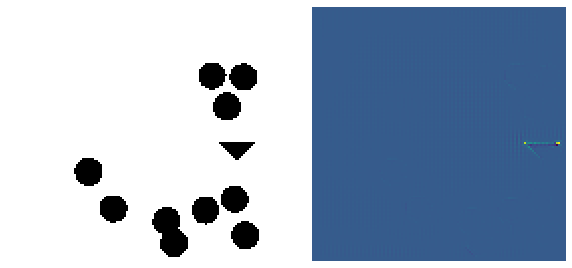

In [92]:
inputi = torch.Tensor(valid_ds[1][0][None,:,:,:]) # Input image for which to calculate the attribution map
ig = IntegratedGradients(model) # Initialize the attribution object with the forward function
target = model(inputi).argmax() # Define the target (the output for which the gradients should be calculated)
attributions = ig.attribute(inputi, target=target) # calculate the attributions
vsubplot(inputi.squeeze().numpy(),attributions.squeeze().numpy()) # plot input and the attribution map

captum implements noise tunneling bz applying techniques which should help to reduce noise in attribution maps
e.g. Smoothgrad https://arxiv.org/abs/1706.03825

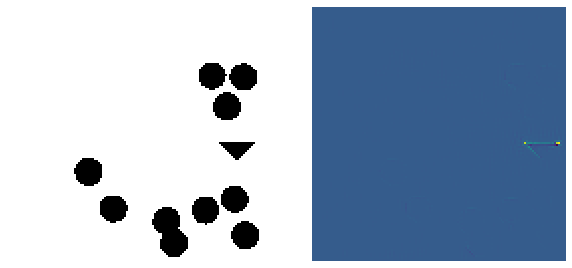

In [93]:
nt = NoiseTunnel(ig) 
attributionsnt = nt.attribute(inputi, nt_type='smoothgrad', stdevs=0.02, n_samples=4,
                                       target=target)
vsubplot(inputi.squeeze().numpy(),attributionsnt.squeeze().numpy())

Deeplist is an alternative attribution tecnique: https://arxiv.org/abs/1704.02685

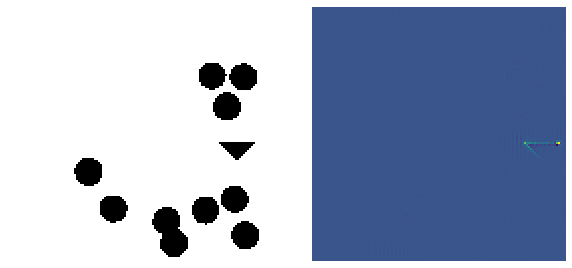

In [94]:
dl = DeepLift(model)
attributionsdl = dl.attribute(inputi, target=target)
vsubplot(inputi.squeeze().numpy(),attributionsdl.detach().squeeze().numpy())

### How does integrated gradients acutally work?

In [203]:
def my_integraded_gradients(model, inputi, target=None, n_steps=50, method='linear'):
    baseline = torch.zeros(inputi.shape)
    
    if method == 'linear':
        scaled_inputs = torch.cat([(baseline + (float(i)/n_steps)*(inputi-baseline)).requires_grad_() for i in range(0, n_steps)])
        step_sizes = [1/n_steps]*n_steps
    elif method:
        step_sizes_func, alphas_func = captum.attr._utils.approximation_methods.approximation_parameters(method)
        step_sizes, alphas = step_sizes_func(n_steps), alphas_func(n_steps)
        scaled_inputs = torch.cat([(baseline + (alphas[i])*(inputi-baseline)).requires_grad_() for i in range(0, n_steps)])
        
    if not target:
        target = model(inputi).argmax()
        print('Target: %d' % target)
    
    sm = torch.nn.Softmax(dim=1)
    output_p = sm(model(scaled_inputs))
    xtens = [p[target] for p in output_p]
    grads = torch.autograd.grad(xtens,scaled_inputs)
    gradsnp = grads[0].squeeze().detach().numpy()
    gradsnp = gradsnp * np.asarray(step_sizes)[:,None,None]
    gradsnp = gradsnp * (inputi-baseline).squeeze().detach().numpy()
    avg_grads = np.sum(gradsnp, axis=0)
    return avg_grads.squeeze()    

Target: 1


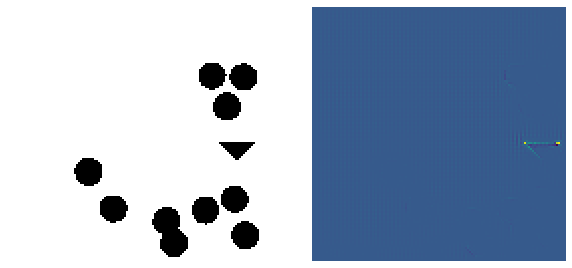

In [208]:
inputi = torch.Tensor(valid_ds[1][0][None,:,:,:])
attributions = my_integraded_gradients(model,inputi, method='linear')
vsubplot(inputi.squeeze().numpy(),attributions)

In [210]:
# n_steps = 50
# step_sizes_func, alphas_func = captum.attr._utils.approximation_methods.approximation_parameters('gausslegendre')
# step_sizes, alphas = step_sizes_func(n_steps), alphas_func(n_steps)
# plt.subplot(1,2,1)
# plt.plot(step_sizes)
# plt.subplot(1,2,2)
# plt.plot(alphas)

### Attributions for class 0 (pyramid pointing upwars) look strange

Some cases with calss 0: [2 3 4 6 7]
tensor(0)


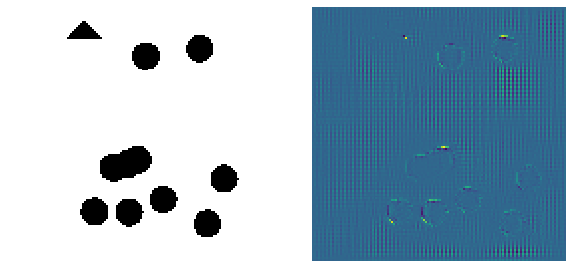

In [21]:
print('Some cases with calss 0: ' + str(np.where(y_valid==0)[0][:5]))
inputi = torch.Tensor(valid_ds[2][0][None,:,:,:])
target = model(inputi).argmax()
print(target)
attributions = ig.attribute(inputi, target=target).detach()
vsubplot(inputi.squeeze().numpy(),attributions.squeeze().numpy())

Maybe its the default class. That is, the model will predit 0 in case no other class is present  
Lets test this by prediting cases which don't show a pyramid

In [22]:
# we can generate images without the pyramid
from skimage import draw
import random
def generate_synth_image(withoutPyramid = False):
    image = np.ones([128,128],np.uint8)
    for i in range(10):
        [x,y] = draw.circle(random.uniform(7,120),random.uniform(7,120),7)
        image[x,y] = 0
    tric = (random.uniform(10,117),random.uniform(10,117))
    if not withoutPyramid:
        [x,y] = draw.polygon([tric[1]+5,tric[1]-5,tric[1]+5],[tric[0]-10,tric[0],tric[0]+10])
        image[x,y] = 0
    return image

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


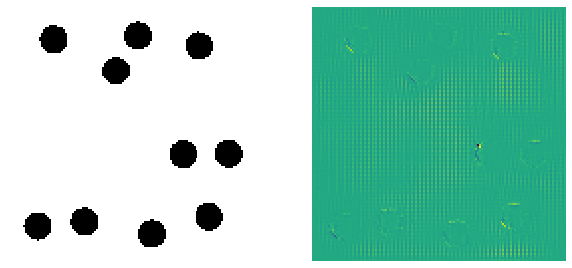

In [28]:
im = np.asarray([generate_synth_image(withoutPyramid=True) for i in range(20)]) # lets generate images without a pyramid
im = (im-mean)/std # we have to normalize them based on the statistics of the training set
inputi = torch.Tensor(im[:,None,:,:])
target = model(inputi).argmax(1)
print(target)
attributions = ig.attribute(inputi[0:1], target=target[0])
vsubplot(inputi[0].squeeze().numpy(),attributions.squeeze().numpy())

## Using pytorch hooks to visualize feature maps

we create a very basic hook class that only stores the activates from a forward pass (hood_fn):

In [29]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

register the hook function on the three convoltional blocks of our network

In [31]:
testhooks = [Hook(i[1]) for i in model.cnn_seq._modules.items()]

Now we need an image for the forward pass and run the forward pass

tensor(0)


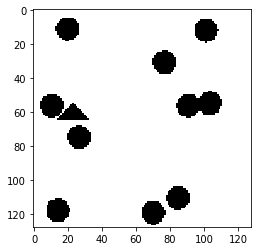

In [36]:
im = generate_synth_image(withoutPyramid=False)
im = (im-mean)/std
inputi = torch.Tensor(im[None,None,:,:])
# run the forward pass
target = model(inputi).argmax()
print(target)
plt.imshow(im,cmap='gray')
# inputi = torch.Tensor(im[None,None,:,:]).transpose(2,3).flip(3)

The feature map activations are now stored in the hook objects. The following function will plot the 3 feature maps which hold the hightest maximum activation (left) and the 3 feature maps which hold the lowest maximum activation (right) for the three convolutional blocks (rows 1-3)

In [41]:
def vis_run(listofHooks, figsize=(20,10)):
    cnt = 0
    f,axes = plt.subplots(len(listofHooks),7, gridspec_kw={'width_ratios': [1,1,1,0.2,1,1,1]},figsize=figsize)
    axes = axes.flatten()
    [a.axis('off') for a in axes]
    for i,hook in enumerate(listofHooks):
        nfeats = testhooks[i].output.shape[1]
        highactive = testhooks[i].output.view(nfeats,-1).max(1)[0].argsort(descending=True)
        for j in range(3):
            axes[cnt].imshow(testhooks[i].output[0][highactive[j]].detach().numpy())
            cnt += 1
        axes[cnt].imshow(np.zeros((100,1)))
        cnt+=1
        for j in range(3):
            axes[cnt].imshow(testhooks[i].output[0][highactive[-1-j]].detach().numpy())
            cnt += 1

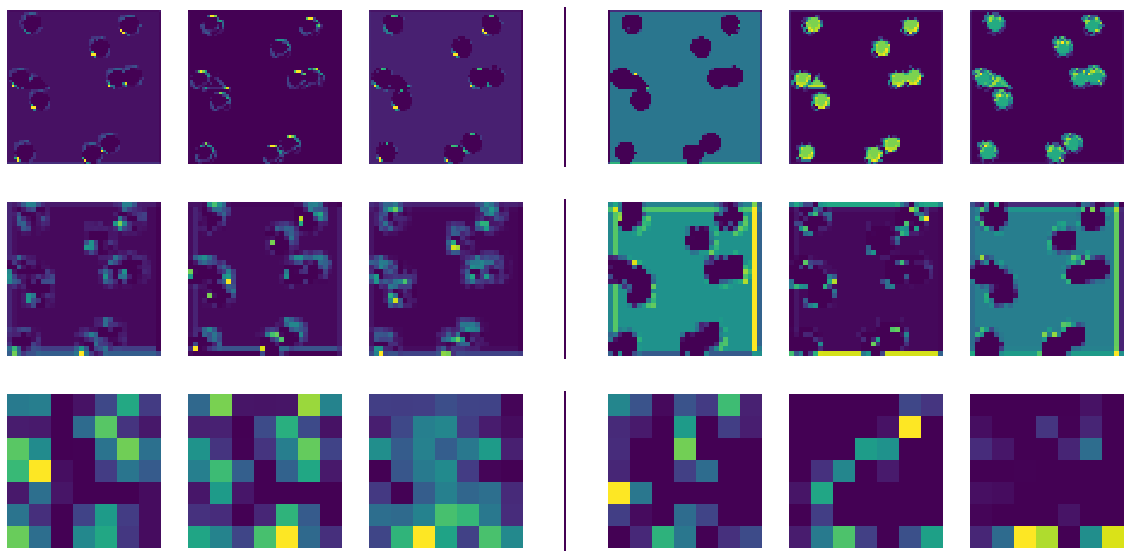

In [42]:
vis_run(testhooks)

tensor(3)


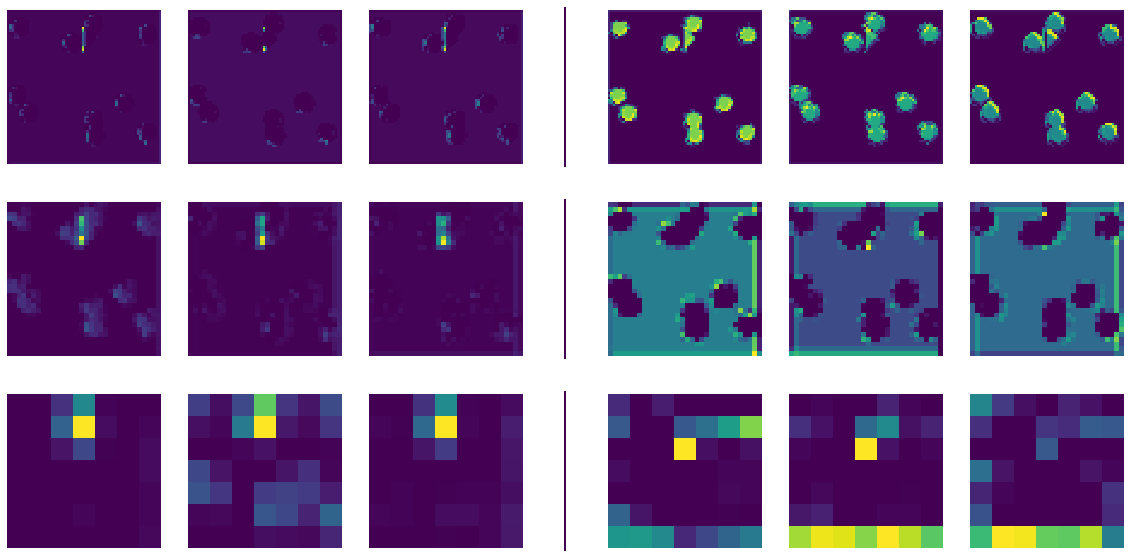

In [48]:
target = model(inputi.flip(2).transpose(2,3)).argmax()
print(target)
vis_run(testhooks)

In [255]:
model

Luke(
  (cnn_seq): Sequential(
    (0): LukeConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout2d(p=0.1, inplace=False)
        (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): ReLU()
        (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): Dropout2d(p=0.1, inplace=False)
        (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): LukeConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout2d(p=0.1, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=